<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Week 5 - Gather Stock price data from API

In this exercise we will practice the activities in CRISP-DM Step 2: Data Understanding, using stock price data from the TDAmeritrade API.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import math
import os
from pathlib import Path
path = Path()

%matplotlib inline

## Gather data

Although there are many sources for stock price data, we will practice collecting data via APIs by using the TD Ameritrade API.  TDAmeritrade provides a <a href=https://developer.tdameritrade.com/price-history/apis/get/marketdata/%7Bsymbol%7D/pricehistory>'Price History' API</a> which one can query to get daily price history on any listed stock.  To access it one must have register for an API key. If you would like to run this notebook on your own, you must first register as a developer to get your own API key, and then plug it in below.

In [60]:
# Load API key (read this in from a config.py file or type it in)
if os.path.exists('config.py'):
    print('Reading in API key from config file')
    import config
    key = config.api_key
else:
    key = input('Please enter your API key:')

Reading in API key from config file


In [61]:
# Set request parameters
stock = 'GOOG'
frequency = 'daily'
num_years = 5

In [76]:
# Function to make the API request
def make_request(stock,frequency,num_years):
    
    # Set endpoint
    endpoint = f'https://api.tdameritrade.com/v1/marketdata/{stock}/pricehistory'

    # Define API payload
    payload = {
        'apikey': key,
        'periodType':'year',
        'period':num_years,
        'frequencyType':frequency,
        'frequency':1,
        'needExtendedHoursData':False
    }
    
    # Make API request
    response = requests.get(url = endpoint, params=payload)
    
    return response

response = make_request(stock, frequency, num_years)

In [77]:
# Look at the response headers
response.headers

{'Date': 'Fri, 11 Sep 2020 16:50:57 GMT', 'Content-Type': 'application/json;charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Encoding': 'gzip', 'Vary': 'Accept-Encoding', 'Cache-Control': 'no-cache,no-store,must-revalidate', 'Access-Control-Allow-Origin': '', 'Access-Control-Allow-Headers': 'origin, x-requested-with, accept, authorization, content-type', 'Access-Control-Max-Age': '3628800', 'Access-Control-Allow-Methods': 'GET, PUT, POST, DELETE, OPTIONS, HEAD, PATCH', 'X-Xss-Protection': '1; mode=block', 'X-Content-Type-Options': 'nosniff', 'X-Frame-Options': 'SAMEORIGIN', 'Content-Security-Policy': "frame-ancestors 'self'", 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains, max-age=31536000'}

In [78]:
# Convert the response into a pandas dataframe for further analysis
def convert_data(response):
    
    # Decode JSON content
    data = response.json()

    # Grab only the quotes ('candles'), strip out everything else
    dailyprices = data['candles']

    # Convert from dictionary to a Pandas dataframe to make it easy to work with
    dailyprices = pd.DataFrame.from_dict(dailyprices, orient='columns')
    
    return dailyprices
    
dailyprices = convert_data(response)
dailyprices.head()

,open,high,low,close,volume,datetime
0,613.10,624.16,611.43,621.35,1905276,1441861200000
1,619.75,625.78,617.42,625.77,1373545,1441947600000
2,625.70,625.86,619.43,623.24,1702271,1442206800000
3,626.70,638.70,623.78,635.14,2084397,1442293200000
4,635.47,637.95,632.32,635.98,1286454,1442379600000


In [70]:
content.headers

{'Date': 'Tue, 08 Sep 2020 19:33:24 GMT', 'Content-Type': 'application/json;charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Encoding': 'gzip', 'Vary': 'Accept-Encoding', 'Cache-Control': 'no-cache,no-store,must-revalidate', 'Access-Control-Allow-Origin': '', 'Access-Control-Allow-Headers': 'origin, x-requested-with, accept, authorization, content-type', 'Access-Control-Max-Age': '3628800', 'Access-Control-Allow-Methods': 'GET, PUT, POST, DELETE, OPTIONS, HEAD, PATCH', 'X-Xss-Protection': '1; mode=block', 'X-Content-Type-Options': 'nosniff', 'X-Frame-Options': 'SAMEORIGIN', 'Content-Security-Policy': "frame-ancestors 'self'", 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains, max-age=31536000'}

## Validate data

From the above, we can see that the dates are not in a format that works well for us.  Let's convert to a more readable format and make it the index of the dataframe

In [22]:
def clean_data (raw_data_df):
    
    dailyprices = raw_data_df.copy()
    
    # Convert dates to pandas datetime format
    dailyprices['date']=pd.to_datetime(dailyprices['datetime'],unit='ms') # Since api data is in ms since epoch, use 'ms' here

    # Set index to new 'date' column
    dailyprices.set_index(keys='date',inplace=True)

    # Drop old datetime column
    dailyprices.drop(columns=['datetime'],inplace=True)
    
    return dailyprices

dailyprices = clean_data(dailyprices)
dailyprices.head()

,open,high,low,close,volume
date,,,,,
2015-09-04 05:00:00,600.00,603.47,595.25,600.70,2089453
2015-09-08 05:00:00,612.49,616.31,604.12,614.66,2279538
2015-09-09 05:00:00,621.22,626.52,609.60,612.72,1702094
2015-09-10 05:00:00,613.10,624.16,611.43,621.35,1905276
2015-09-11 05:00:00,619.75,625.78,617.42,625.77,1373545


## Explore data

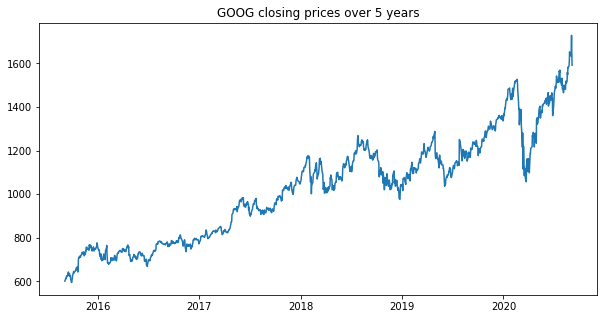

In [16]:
# Plot the data - as an example let's plot the closing prices
plt.figure(figsize=(10,5))
plt.plot(dailyprices['close'])
plt.title(f'{stock} closing prices over {num_years} years')
plt.show()

# Week 6 - Analyze Apple vs Google stock returns

Now let's compare the stock returns of both Google and Apple, using the data from the API

## Gather and validate data

In [24]:
# Set API request parameters
stocks = ['GOOG','AAPL']
frequency = 'daily'
num_years = 5

# Set up dictionary to hold results
stockdata = {}

for stock in stocks:
    # Get the price data from API
    dailyprices = get_prices(stock,frequency,num_years)
    # Clean up
    dailyprices = clean_data(dailyprices)
    # Store in dictionary
    stockdata[stock] = dailyprices

## Explore data

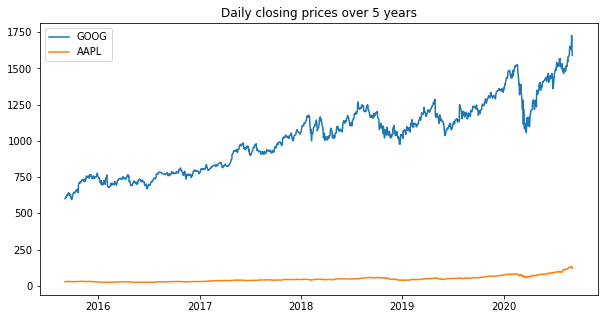

In [34]:
# Now let's plot the closing prices of both AAPL and GOOG
plt.figure(figsize=(10,5))
for stock in stocks:
    plt.plot(stockdata[stock]['close'])
    
plt.title(f'Daily closing prices over {num_years} years') # Add title
plt.legend(labels=[stock for stock in stocks])
plt.show()

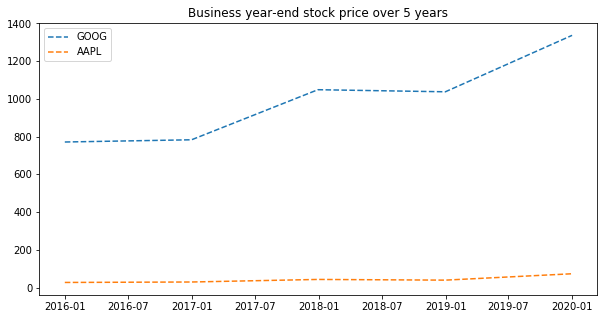

In [42]:
# Let's plot each stock's business year-end stock price over the time period

plt.figure(figsize=(10,5))

for stock in stocks:
    plt.plot(stockdata[stock]['close'].asfreq('BA',method='ffill'),linestyle='dashed') # Use BA for business year

plt.title(f'Business year-end stock price over {num_years} years') # Add title
plt.legend(labels=[stock for stock in stocks])
plt.show()

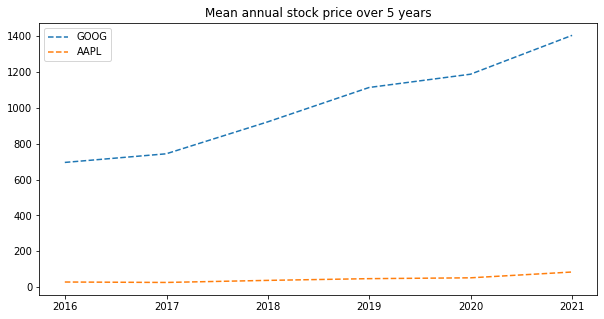

In [43]:
# Plot the yearly mean price for each stock

plt.figure(figsize=(10,5))

for stock in stocks:
    plt.plot(stockdata[stock]['close'].resample('BA').mean(),linestyle='dashed')
    
plt.title(f'Mean annual stock price over {num_years} years') # Add title
plt.legend(labels=[stock for stock in stocks])
plt.show()

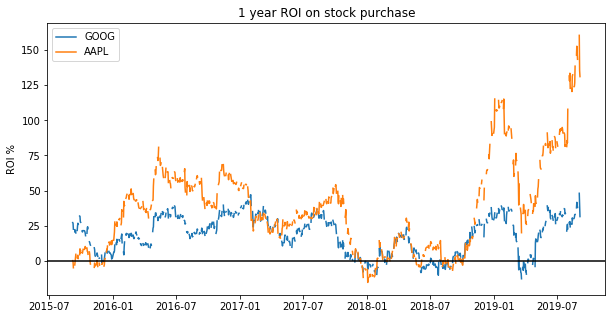

In [58]:
# Look at the one-year ROI for an investment made in each stock on that day

roi = {}

# Calculate one-year ROI for each day
# 1yr ROI = 100% * (stock price 1yr later - initial stock purchase price)/(initial stock purchase price)
for stock in stocks:
    roi[stock] = 100 * ((stockdata[stock]['close'].tshift(-365,freq='D')-(stockdata[stock]['close']-1)) / 
                        (stockdata[stock]['close']-1))
    
plt.figure(figsize=(10,5))

for stock in stocks:
    plt.plot(roi[stock])

plt.title('1 year ROI on stock purchase')
plt.legend(labels=[stock for stock in stocks])
plt.ylabel('ROI %') 
plt.axhline(color='black')
plt.show()